In [55]:
from models.FilmModelEvaluator import FiLMModelEvaluator
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
def calculate_edistance(X, Y):
    """
    Calculate edistances between two matrices
    """
    sigma_X = pairwise_distances(X, X, metric="sqeuclidean").mean()
    sigma_Y = pairwise_distances(Y, Y, metric="sqeuclidean").mean()
    delta = pairwise_distances(X, Y, metric="sqeuclidean").mean()
    return 2 * delta - sigma_X - sigma_Y

def format_test_results(test_results_raw):
    """
    Eliminate negative data points from the results
    """

    test_results_formatted = test_results_raw[test_results_raw['compound'] != None]
    test_results_formatted = test_results_formatted[test_results_formatted['dose'] != 0]

    return test_results_formatted


def get_model_stats(formatted_test_results):
    """
    Calculate test results statistics
    """

    results_pred_loss = dict()
    results_null_loss = dict()
    results_PCP = dict()
    results_PR = dict()


    for cell_type in formatted_test_results['cell_type'].unique():
        losses = list()

        df_subset = formatted_test_results[formatted_test_results['cell_type'] == cell_type]

        for compound in tqdm(list(formatted_test_results['compound'].unique())):
            distances_to_ctrl = list()
            for dose in sorted(formatted_test_results['dose'].unique()):
                df_subset = formatted_test_results[(formatted_test_results['cell_type'] == cell_type) &
                                         (formatted_test_results['compound'] == compound) &
                                         (formatted_test_results['dose'] == dose)]

                ctrl_X = np.array(df_subset['ctrl_emb'].tolist())
                pert_X = np.array(df_subset['pert_emb'].tolist())
                pred_X = np.array(df_subset['pred_emb'].tolist())

                edist_ctrl_pert = calculate_edistance(ctrl_X, pert_X)
                edist_ctrl_pred = calculate_edistance(ctrl_X, pred_X)
                edist_pert_pred = calculate_edistance(pert_X, pred_X)

                distances_to_ctrl.append(edist_ctrl_pred)

                is_closer = None
                if edist_pert_pred < edist_ctrl_pred:
                    is_closer = True
                else:
                    is_closer = False

                key1 = cell_type + "_" + compound + "_" + str(dose)
                results_pred_loss[key1] = edist_pert_pred
                results_null_loss[key1] = edist_ctrl_pert
                results_PCP[key1] = is_closer

            corr, _ = spearmanr(list(formatted_test_results['dose'].unique()), distances_to_ctrl)
            key2 = cell_type + "_" + compound
            results_PR[key2] = corr

        
    return results_pred_loss, results_null_loss, results_PCP, results_PR

def get_res_stratified(results, cell_type, dose):
    out = list()
    for key, value in results.items():
        ct = key.split("_")[0]
        ds = float(key.split("_")[2])

        if ct == cell_type and ds == dose:
            out.append(value) 

    return out

In [57]:
eval = FiLMModelEvaluator("../../config/FiLM.yaml")
eval.train()
eval.test()

Loading sciplex train dataset ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571906/571906 [02:20<00:00, 4077.11it/s]


Loading sciplex test dataset ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571906/571906 [00:59<00:00, 9628.44it/s]


Begin training ...
Epoch 1/2
Iteration: 10 Loss: 0.05236933380365372
Iteration: 20 Loss: 0.013187414966523647
Iteration: 30 Loss: 0.005214120727032423
Iteration: 40 Loss: 0.0031380720902234316
Iteration: 50 Loss: 0.0022571058943867683
Iteration: 60 Loss: 0.001842162455432117
Iteration: 70 Loss: 0.0016143600223585963
Iteration: 80 Loss: 0.0014829103602096438
Iteration: 90 Loss: 0.0013420034665614367
Iteration: 100 Loss: 0.0012386083835735917
Iteration: 110 Loss: 0.0011413733009248972
Iteration: 120 Loss: 0.001101822592318058
Iteration: 130 Loss: 0.0009899878641590476
Iteration: 140 Loss: 0.0009768056916072965
Iteration: 150 Loss: 0.0008929147734306753
Iteration: 160 Loss: 0.0008777109906077385
Iteration: 170 Loss: 0.0008252255502156913
Iteration: 180 Loss: 0.0007975110784173012
Iteration: 190 Loss: 0.0007388698868453503
Iteration: 200 Loss: 0.0006870642537251115
Iteration: 210 Loss: 0.0006612028810195625
Iteration: 220 Loss: 0.0006553360144607723
Iteration: 230 Loss: 0.00060110999038442

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:04<00:00, 59.57it/s]

Testing completed. Results stored in 'self.test_results'.


In [60]:
results = eval.get_test_results()
results_formatted = get_model_stats(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  3.75it/s]


In [64]:
def plot_results(results_formatted, cell_type):
    predloss_10 = get_res_stratified(results_formatted[0], cell_type, 10.0)
    predloss_100 = get_res_stratified(results_formatted[0], cell_type, 100.0)
    predloss_1000 = get_res_stratified(results_formatted[0], cell_type, 1000.0)
    predloss_10000 = get_res_stratified(results_formatted[0], cell_type, 10000.0)
    
    nullloss_10 = get_res_stratified(results_formatted[1], cell_type, 10.0)
    nullloss_100 = get_res_stratified(results_formatted[1], cell_type, 100.0)
    nullloss_1000 = get_res_stratified(results_formatted[1], cell_type, 1000.0)
    nullloss_10000 = get_res_stratified(results_formatted[1], cell_type, 10000.0)

    # Group the lists into pairs
    data = [predloss_10, nullloss_10, predloss_100, nullloss_100, predloss_1000, nullloss_1000, predloss_10000, nullloss_10000]

    # Create boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, width=0.15, showmeans=True)
    
    # Adjust x-ticks to group pairs
    plt.xticks(ticks=range(8), labels=["Pred_10", "Null_10", "Pred_100", "Null_100", "Pred_1000", "Null_1000", "Pred_10000", "Null_10000"])
    plt.title(cell_type)
    plt.xlabel("Dosage")
    plt.ylabel("E-distance")
    
    plt.show()

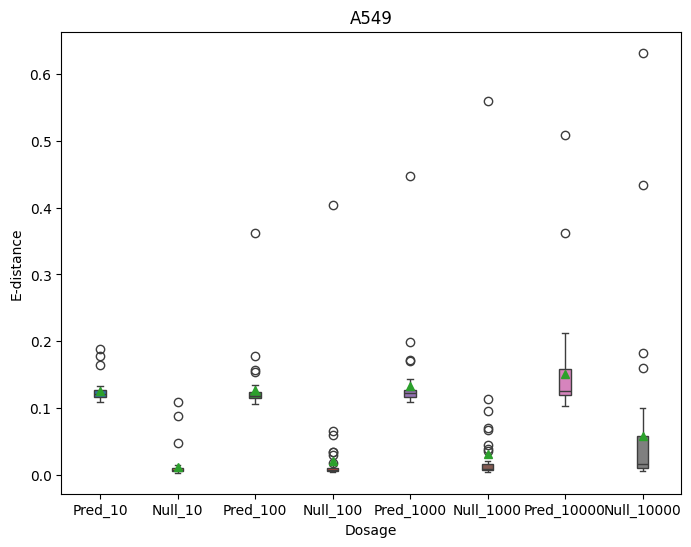

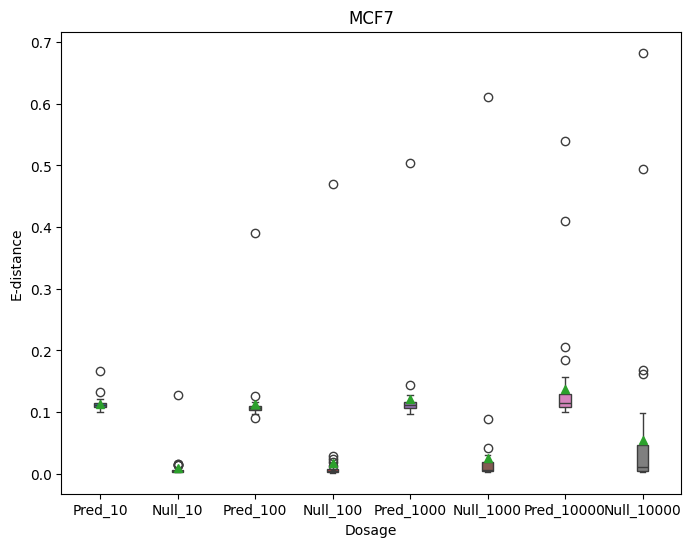

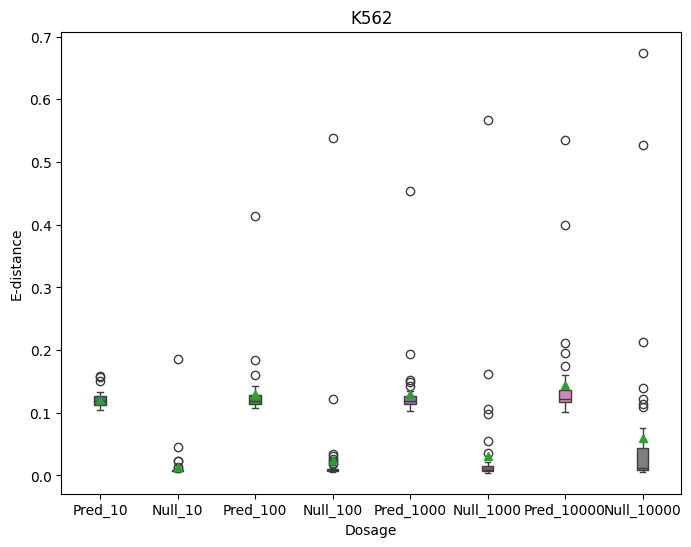

In [65]:
plot_results(results_formatted, "A549")
plot_results(results_formatted, "MCF7")
plot_results(results_formatted, "K562")